In [1]:
from IPython import display
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from gym.envs.mujoco import *
from envs.hopper_env import HopperModEnv
from envs.cheetah_env import CheetahModEnv
import numpy as np
import copy
import gym
from scipy.io import loadmat
from scipy.io import savemat
import moviepy.editor as mpy
from simulators import *
from rot_utils import *
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
os.environ["PYOPENGL_PLATFORM"] = "osmesa"

#### (a) LQR for Linear Systems

Let's start with a linear system:

In [3]:
A = np.array([[0.0481, -0.5049, 0.0299, 2.6544, 1.0608],
              [2.3846, -0.2312, -0.1260, -0.7945, 0.5279],
              [1.4019, -0.6394, -0.1401, 0.5484, 0.1624],
              [-0.0254, 0.4595, -0.0862, 2.1750, 1.1012],
              [0.5172, 0.5060, 1.6579, -0.9407, -1.4441]])  #constant state matrix
B = np.array([[-0.7789, -1.2076],
              [0.4299, -1.6041],
              [0.2006, -1.7395],
              [0.8302, 0.2295],
              [-1.8465, 1.2780]])   #constant control matrix
dx = A.shape[0]  #To define the placeholder matrix, we are getting the shape.
du = B.shape[1]  

Now verify the system is controllable.

To do so we need to check if rank($[B \; AB \; A^2B \; A^3B \; A^4B]$) == 5. (generally we'd go up to $A^{(n-1)}B$, and verify rank == n)

In [4]:
# verify the above statement
lst = [B]
"""YOUR CODE HERE"""
col = np.shape(A)[1]    #Getting number of columns
for i in range(1,col):
    lst.append(np.matmul(np.power(A,i),B)) #[B,AB,A2B,A3B,A4B]

"""YOUR CODE ENDS HERE"""
np.linalg.matrix_rank(np.hstack(lst)) #Rank checking condition.

5

Recall the following optimal control problem:
$$\min_{x,u} \sum_{t=0}^{T-1} (x_t' Q x_t + u_t' R u_t) + x_{T}' Q_{final} x_{T} \\ \text{s.t. }x_{t+1} = A x_t + B u_t$$
 

For $T$ going to infinity, we'll have that the Value Function and the
Feedback Controller at time $t=0$ reach a steady-state --- the optimal
value function and feedback controller for infinitely many time-steps to-go

So let's run the Value Iteration Solution to the LQR control problem
until it has converged, and then use that infinite horizon optimal
feedback controller to stabilize our system at 0. 

In [5]:
# implement the infinite horizon optimal feedback controller
def lqr_infinite_horizon(A, B, Q, R):
    """
    find the infinite horizon K and P through running LQR back-ups
    until l2-norm(K_new - K_curr, 2) <= 1e-4
    return: K, P
    """
    
    dx, du = A.shape[0], B.shape[1]
    P, K_current = np.eye(dx), np.zeros((du, dx))
    
    """YOUR CODE HERE"""
    diff_norm = np.inf              #Initializing norm as infinity
    while diff_norm > 1e-4:         #Checking for the norm condition
        K_new = -np.linalg.inv(R + B.T@P@B) @ (B.T@P@A) #FInding K for each iteration using K = -(R+B.TPB)^-1. B.TPA
        P = Q+(K_current.T@R@K_current) + (A+(B@K_current)).T @ P @ (A + (B@K_current)) # P = Q +K.TRK + (A+BK).T P (A+BK)
        diff_norm = np.linalg.norm(K_new - K_current,2)     #Updating norm condition value
        K_current = K_new   #Updaing K value for the next iteration.
    
    """YOUR CODE ENDS HERE"""
    return K_new, P

In [6]:
# problem has been defined, let's solve it:
Q, R = np.eye(dx), np.eye(du)
K_inf, P_inf = lqr_infinite_horizon(A, B, Q, R)

Now let's simulate and see what happens for a few different starting states. 

Here's what a reference plot looks like for the _first starting state with no noise_ in state dynamics so you may compare:
![](img/ref_a.png)

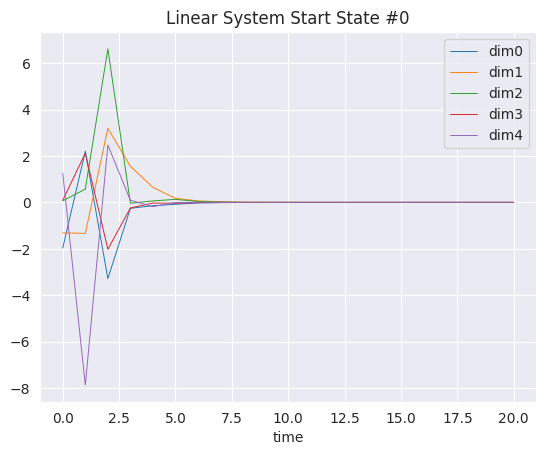

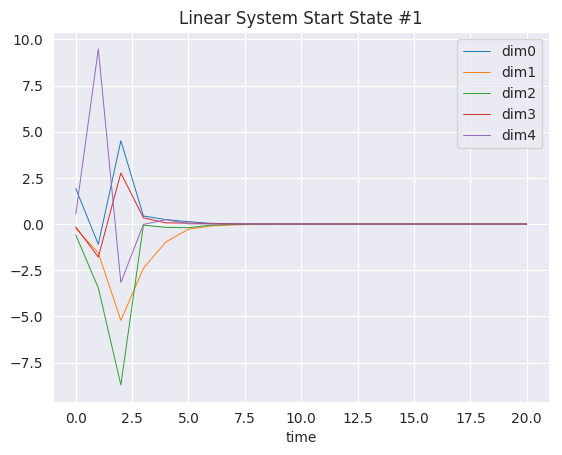

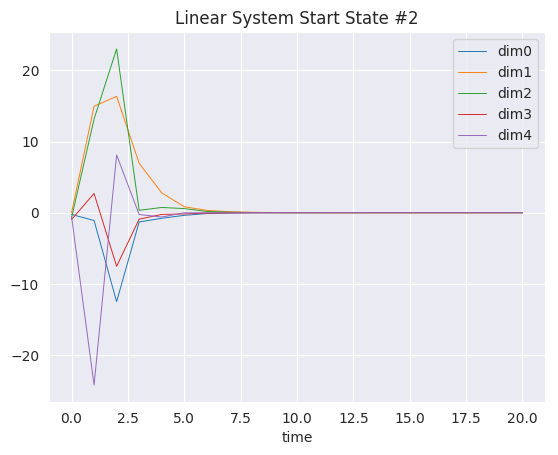

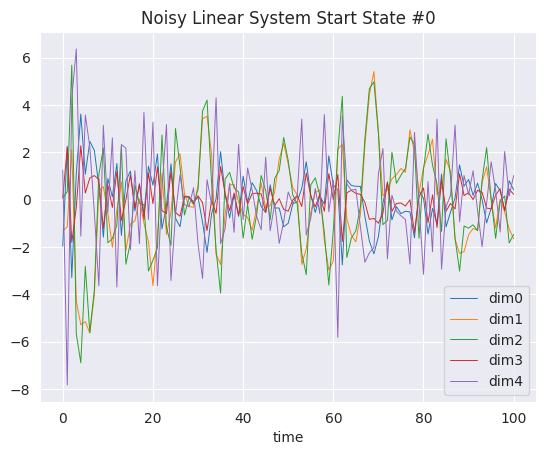

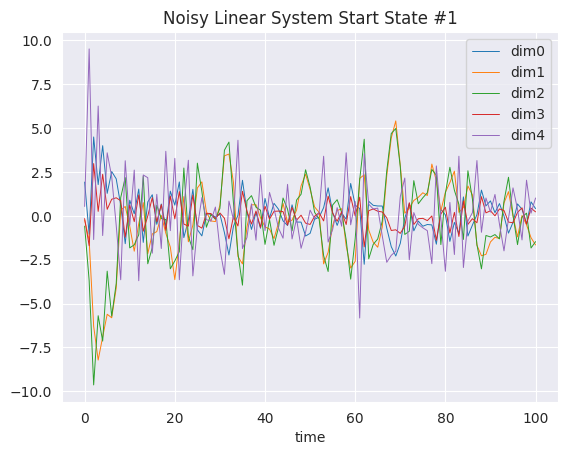

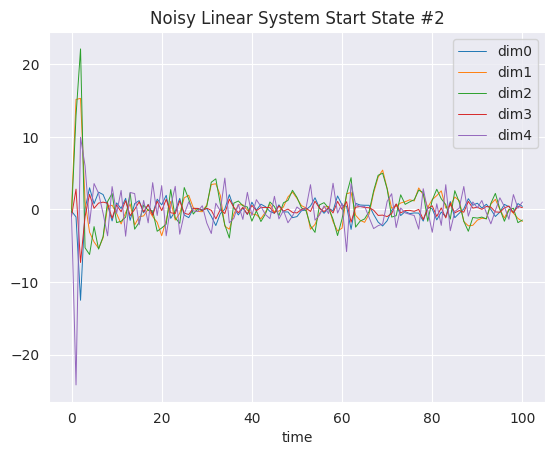

In [7]:
# fill in the simulation to use your controller, K_inf, at each timestep then run the cell to generate plots
def simulate(A, B, K_inf, n_starting_states, T, noise=None):
    for s in np.arange(n_starting_states):
        x, u = np.zeros((K_inf.shape[1], T+1)), np.zeros((K_inf.shape[0], T+1))
        x[:,0] = starting_states[:,s]
        for t in np.arange(T):
            """YOUR CODE HERE"""
            u[:,t] = K_inf@x[:,t]       #U = KX
            """YOUR CODE ENDS HERE"""
            x[:,t+1] = A @ x[:,t] + B @ u[:,t]
            if noise is not None:
                x[:,t+1] += noise[:,t]
        plt.plot(x.T, linewidth=.7)
        plt.xlabel('time')
        plt.title("Noisy Linear System Start State #{}".format(s)) if noise is not None else plt.title("Linear System Start State #{}".format(s))
        plt.legend(["dim"+str(i) for i in range(len(x))])
        plt.show()
        
        
starting_states = np.array([[-1.9613, 1.9277, -0.2442],
                            [-1.3127, -0.2406, -0.0260],
                            [0.0698, -0.5860, -0.7522],
                            [0.0935, -0.1524, -0.9680],
                            [1.2494, 0.5397, -0.5146]])
n_starting_states = starting_states.shape[1]
T = 20 # simulating for 20 steps
simulate(A, B, K_inf, n_starting_states, T)

# and in the presence of noise:
noise_id = "p_a_w"
T = 100 # simulating for 100 steps
simulate(A, B, K_inf, n_starting_states, T, noise=loadmat("mats/"+noise_id+".mat")[noise_id])

#### (b) LQR-based Stabilization for Nonlinear Systems

Now let's consider nonlinear systems. Linearize around one point and design an infinite horizon controller for the resulting system. 

In [8]:
# implement linearization about a point
def linearize_dynamics(f, x_ref, u_ref, dt, my_eps, x_ref_tplus1=None):
    """
    f : dynamics simulator
    my_eps : delta for forward and backward differences you'll need
    NOTE: please use centered finite differences!
    
    x(:,t+1) - x_ref  approximately = A*( x(:,t)-x_ref ) + B* ( u(:,t) - u_ref ) + c
    If we pick x_ref and u_ref to constitute a fixed point, then c == 0 
    
    For part (b), you do not need to use the optional argument (nor c).
    For part (d), you'll have to revisit and modify this function 
        --at this point, you'll want to use the optional argument and the resulting c. 
    
    return: A, B, c
    """
    
    if x_ref_tplus1 is not None:
        x_ref_next = x_ref_tplus1
    else:
        x_ref_next = x_ref
    
    dx, du = x_ref.shape[0], u_ref.shape[0]
    A, B = np.zeros((dx, dx)), np.zeros((dx, du))
    
    """YOUR CODE HERE"""
      
    

    for i in range(dx):
        dx_i = np.zeros(dx) #dx is the vector which holds all state variables
        dx_i[i] = my_eps    #Perturbation my_eps assigned to specific state variable
        f_plus = f(x_ref+dx_i,u_ref,dt)
        f_minus = f(x_ref,u_ref,dt)
        A[:,i] = (f_plus-f_minus)/(my_eps)    #centered finite differences formula

    for j in range(du):
        du_i = np.zeros(du) #du is the vector which holds all control variables
        du_i[j] = my_eps   #Perturbation my_eps assigned to specific control variable
        f_plus = f(x_ref,u_ref+du_i,dt)
        f_minus = f(x_ref,u_ref,dt)
        B[:,j] = (f_plus-f_minus)/(my_eps) #centered finite differences formula

    """YOUR CODE ENDS HERE"""
    
    c = f(x_ref, u_ref, dt) - x_ref_next
    if len(B.shape) == 1:
        return A, B.reshape(-1, 1), c
    return A, B, c

In [9]:
# take an environment and find the infinite horizon controller for the linearized system
def lqr_nonlinear(config):
    env = config['env']
    f = config['f']
    dt = 0.1 # we work with discrete time
    my_eps = 0.01 # finite difference for numerical differentiation
    
    # load in our reference points 
    x_ref, u_ref = config['x_ref'], config['u_ref']
    
    # linearize
    A, B, c = linearize_dynamics(f, x_ref, u_ref, dt, my_eps)
    dx, du = A.shape[0], B.shape[1]
    Q, R = np.eye(dx), np.eye(du)*2
    
    # solve for the linearized system
    K_inf, P_inf = lqr_infinite_horizon(A, B, Q, R) # you implemented in part (a)
    
    # recognize the simulation code from part (a)? modify it to use your controller at each timestep
    def simulate(K_inf, f, x_ref, u_ref, dt, n_starting_states, T, noise=None):
        for s in np.arange(n_starting_states):
            x, u = np.zeros((K_inf.shape[1], T+1)), np.zeros((K_inf.shape[0], T+1))
            x[:,0] = starting_states[:,s]
            for t in np.arange(T):
                """YOUR CODE HERE"""
                u[:,t] = K_inf @ (x[:,t] - x_ref) + u_ref
                """YOUR CODE ENDS HERE"""
                x[:,t+1] = f(x[:,t], u[:,t], dt)
                if "p_val" in config.keys():
                    perturbation_values = config["p_val"]
                    perturb = perturbation_values[t//(T//len(perturbation_values))]
                    x[:,t+1] = f(x[:,t], u[:,t], dt, rollout=True,perturb=perturb)
                if env is not None:
                    if t % 5 == 0:
                        plt.clf()
                        plt.axis('off')
                        plt.grid(b=None)
                        plt.imshow(env.render(mode='rgb_array', width=256, height=256))
                        plt.title("Perturbation Magnitude {}".format(perturb))
                        display.clear_output(wait=True)
                        display.display(plt.gcf())
                
                if noise is not None:
                    x[:,t+1] += noise[:,t]
            if env is not None:
                plt.clf()
        
            plt.plot(x.T[:-1], linewidth=.6)
            plt.plot(np.squeeze(u.T[:-1])/10.0, linewidth=.7, linestyle='--') # scaling for clarity
            if 'legend' in config.keys():
                config['legend'].append('u')
                plt.legend(config['legend'])
            else:
                legend_elements = [Line2D([0], [0], label='x'),Line2D([0], [0], linestyle='--', label='u')]
                plt.legend(handles=legend_elements)
            plt.xlabel('time')
            plt.title(config["exp_name"])
            plt.show()
        
    # now let's simulate and see what happens for a few different starting states
    starting_states = config['ss']
    n_starting_states = starting_states.shape[1]
    T = config['steps'] # simulating for T steps
    simulate(K_inf, f, x_ref, u_ref, dt, n_starting_states, T)
    if 'noise' in config.keys():
        # and now in the presence of noise
        noise_id = config['noise']
        noise_loaded = loadmat("mats/"+noise_id+".mat")[noise_id]
        simulate(K_inf, f, x_ref, u_ref, dt, n_starting_states, noise_loaded.shape[1], noise=noise_loaded)

##### Cartpole-Balancing

Here's what a reference plot looks like for the _first starting state with no noise_ in state dynamics so you may compare:
![](img/ref_b_cartpole.png)

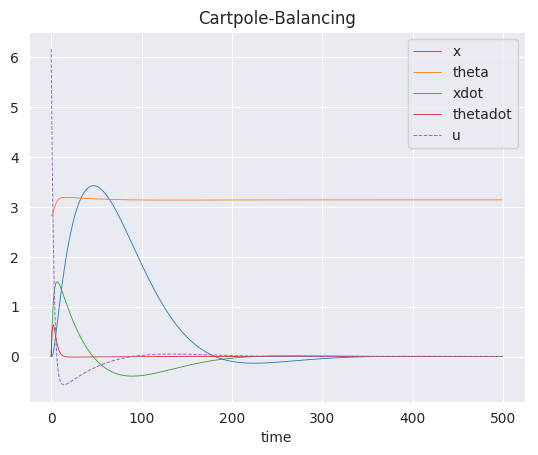

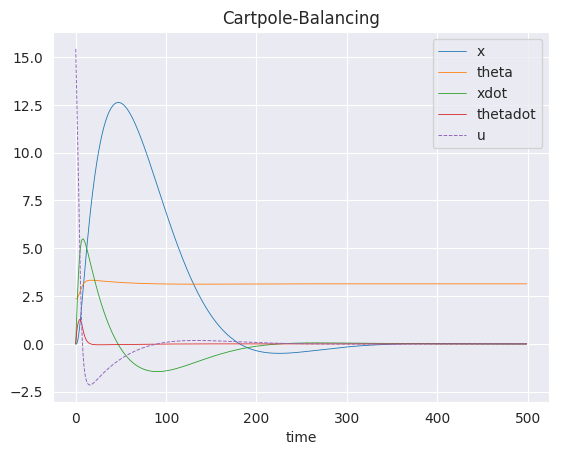

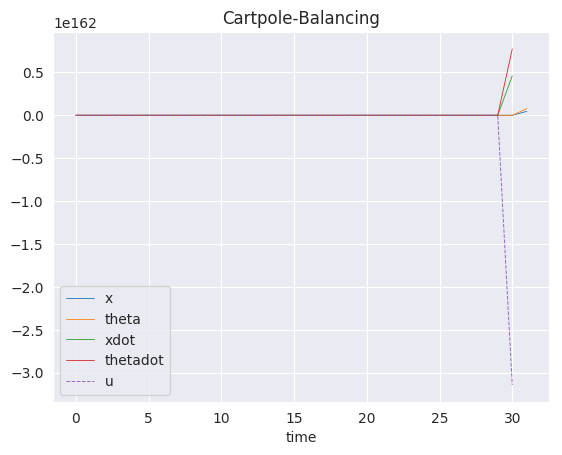

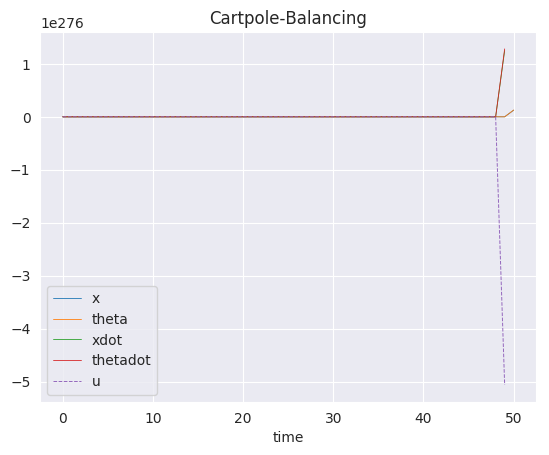

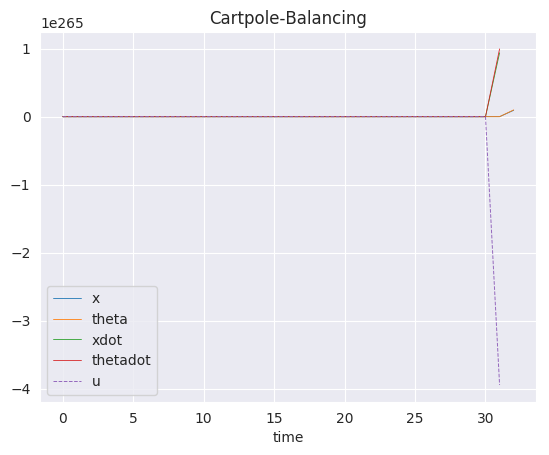

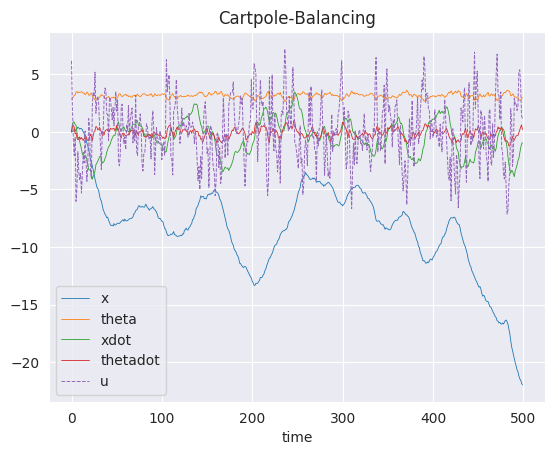

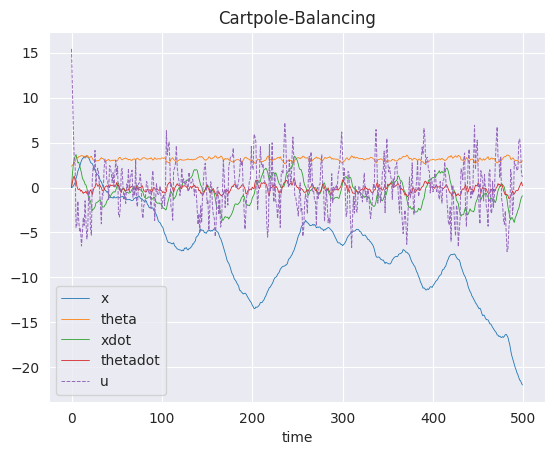

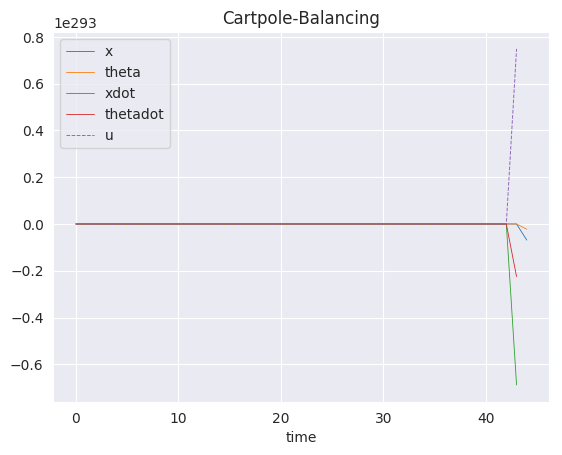

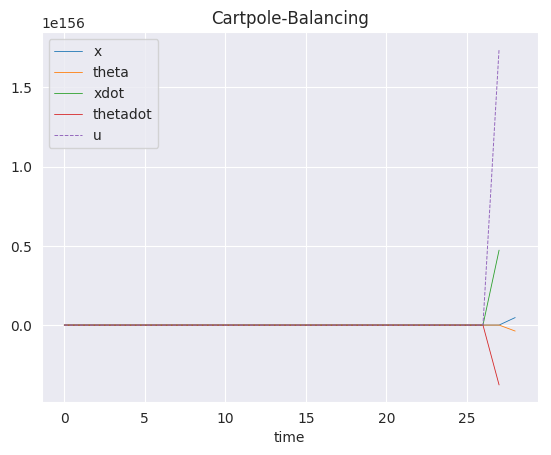

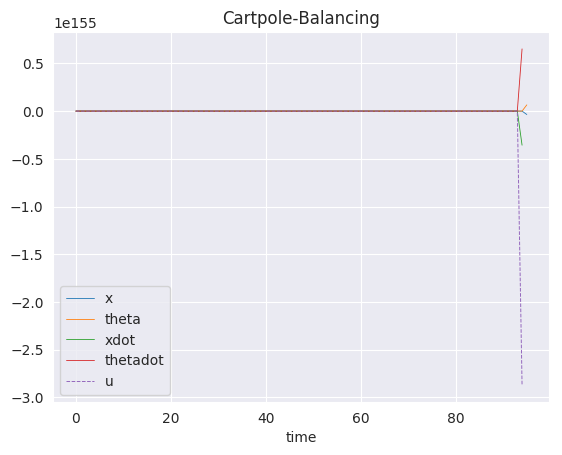

In [10]:
# Find the infinite horizon controller for the linearized version of the cartpole balancing problem
cartpole_config = {
    'f': sim_cartpole,
    'exp_name': "Cartpole-Balancing",
    'env': None,
    'steps': 500,
    'x_ref': np.array([0, np.pi, 0, 0]),
    'u_ref': np.array([0]),
    'legend':['x', 'theta', 'xdot', 'thetadot'],
    'ss': np.array([[0, 0, 0, 10, 50],
                    [9*np.pi/10, 3*np.pi/4, np.pi/2, 0, 0],
                    [0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0]]), #ss = starting states
    'noise': 'p_b_w',
}
lqr_nonlinear(cartpole_config)

**Question:** Inspecting the generated plots for the system without noise, explain in 2-3 sentences how the different starting states affect the problem differently. In your answer, include an analysis of one starting state which causes failure and explain why this might happen.

<span style="color:blue">**Response:** TODO  </span>

##### Helicopter in Hover

Now let's stabilize a helicopter in hover. We can use the *same* code written for the cartpole system to do so; simply run the cell below which defines the fixed point. Here's what a reference plot looks like for the _first starting state with no noise_ in state dynamics so you may compare:
![](img/ref_b_heli.png)

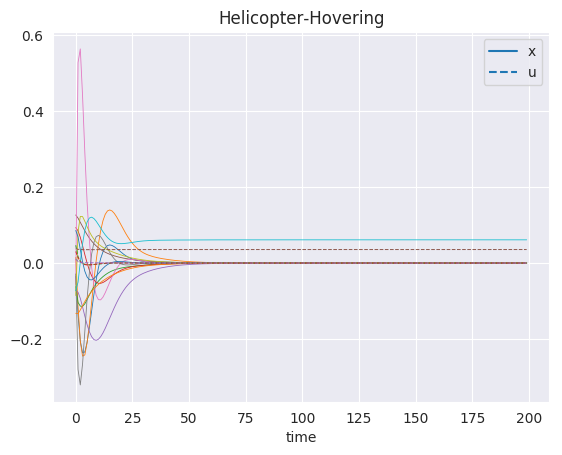

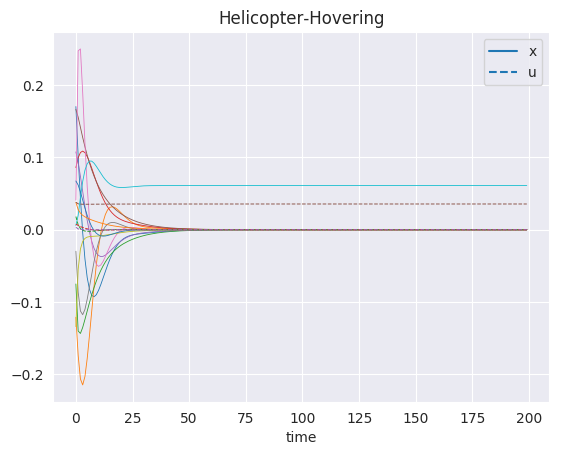

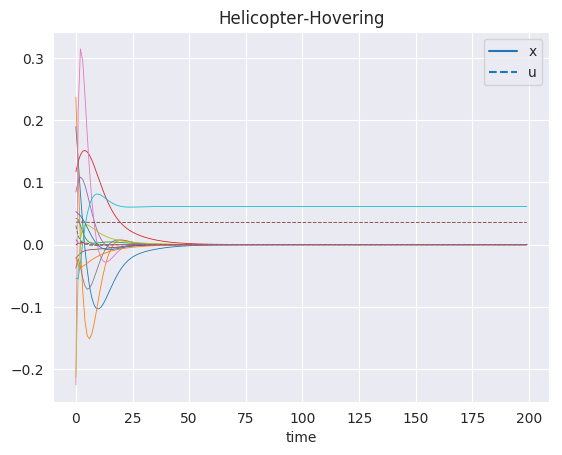

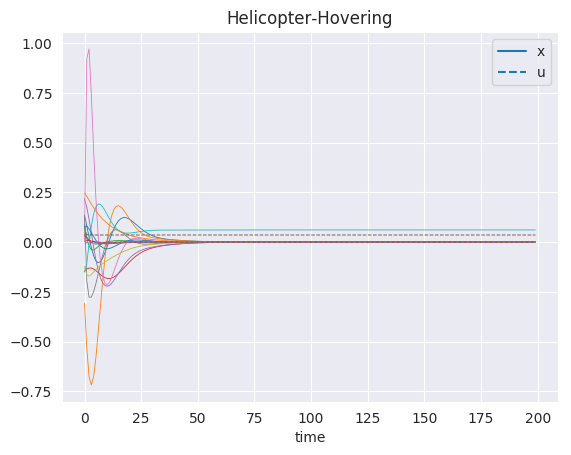

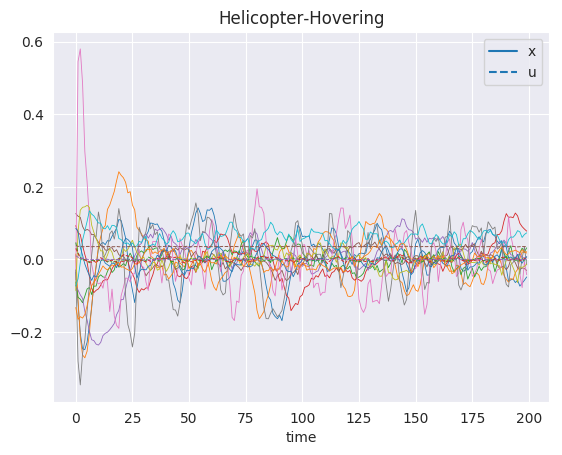

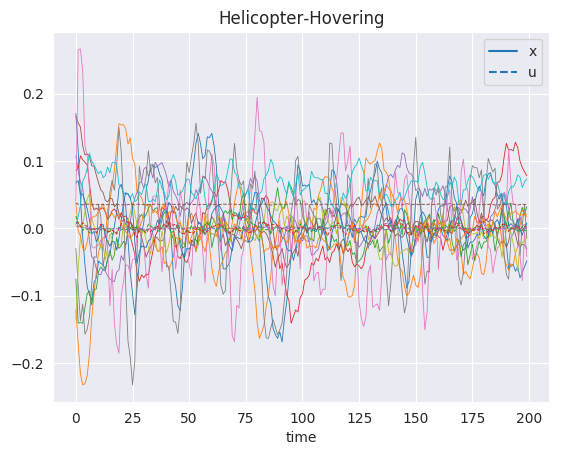

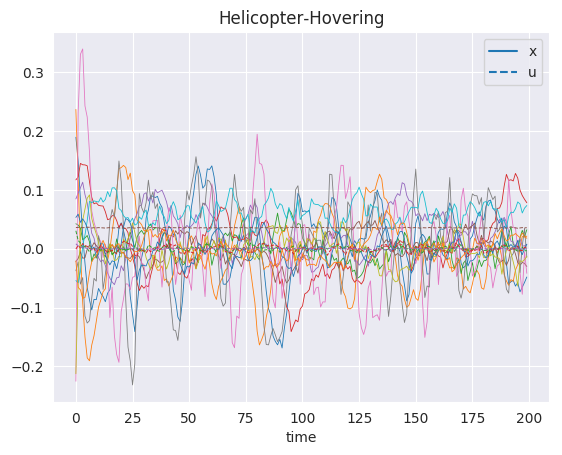

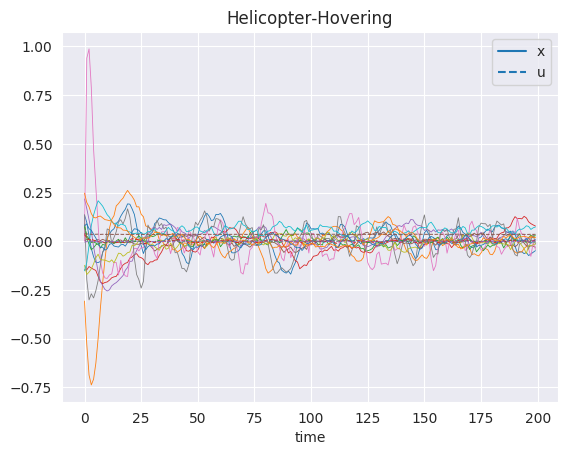

In [11]:
# Find the infinite horizon controller for the linearized version of the hovering copter
# Just run the cell below to generate plots using the code you wrote for cartpole!
x_ref, u_ref = np.zeros(12), np.zeros(4)
x_ref[9] = np.arcsin(3.0/(5*9.81)) 
u_ref[3] = 9.81*5*np.cos(x_ref[9])/137.5
heli_config = {
    'f': sim_heli,
    'env': None,
    'exp_name': "Helicopter-Hovering",
    'steps': 200,
    'x_ref': x_ref,
    'u_ref': u_ref,
    'ss': loadmat("mats/p_c_heli_starting_states.mat")["heli_starting_states"], #ss = starting states
    'noise': 'p_c_w',
}
lqr_nonlinear(heli_config)

##### Gym Environments

Now we'll test on some environments you may be familiar with now. 

We want to keep the robots fixed upright. I've provided the fixed points, try to keep them stabilized and observe the resulting behavior (under different levels of perturbations). For example, in the hopper, we want to exhibit the behavior in the clip on the right. When running the following cells, you should see a video rendering in the notebook. The highlighted joints show which joints are being perturbed; your job is to stabilize.

![SegmentLocal](vids/visualization_hopper.gif "segment")

RuntimeError: Failed to initialize OpenGL

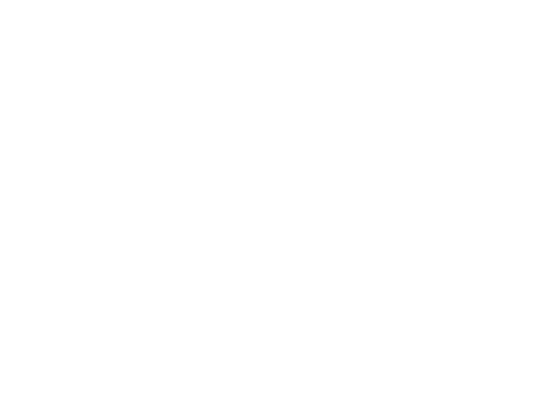

In [12]:
env = HopperModEnv()
x_ref, u_ref = np.zeros(11), np.zeros(env.action_space.sample().shape[0])
hopper_config = {
    'env': env,
    'f': env.f_sim,
    'exp_name': "Perturbed Hopper",
    'steps': 500,
    'x_ref': x_ref,
    'u_ref': u_ref,
    'ss':  np.array([[np.concatenate([env.init_qpos[1:],env.init_qvel])]]),
    'p_val': [0, .1, 1, 10]
}
lqr_nonlinear(hopper_config)

RuntimeError: Failed to initialize OpenGL

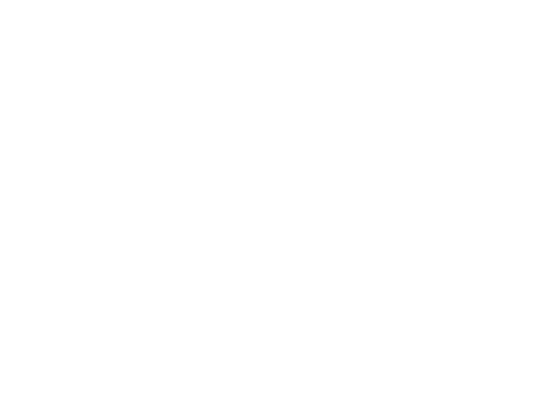

In [13]:
env = CheetahModEnv()
# here's a fixed point I generated using a little magic:
u_ref = np.zeros(env.action_space.sample().shape[0])
x_ref = np.array([-1.40206503e-02, -1.30077635e-01,  4.98998886e-02,  3.34712203e-02
                  ,6.45586857e-02, -1.40762470e-02, -5.68323106e-02, -1.31026327e-01
                 ,-1.21501338e-01,  1.38522957e-05, -6.43600095e-05,  2.83042238e-05
                  ,1.45850734e-04,  1.18368438e-04,  1.35731406e-04, -1.71161017e-04
                 ,-1.57742919e-04, -1.54620176e-04])

cheetah_config = {
    'env': env,
    'f': env.f_sim,
    'exp_name': "Perturbed Cheetah",
    'steps': 500,
    'x_ref': x_ref,
    'u_ref': u_ref,
    'ss':  np.array([[np.concatenate([env.init_qpos[:],env.init_qvel])]]),
    'p_val': [0, 1, 10, 100]
}
lqr_nonlinear(cheetah_config)

#### (c) Linear Time Varying (LTV) Systems

Now we'll consider LTV systems, i.e., $x_{t+1} = A_tx_t + B_tu_t$ (and $Q, R$ may be time-dependent). Our optimal control problem is thus:

$$\min_{x,u} \sum_{t=1}^T (x_t' Q_t x_t + u_t' R_t u_t) + x_{T+1}' Q_{T} x_{T+1} \\ \text{s.t. }x_{t+1} = A_t x_t + B_t u_t$$


Eyeball your plots to sanity check your implementation as this will be important for part (d)!

In [14]:
# implement a finite horizon optimal feedback controller, accounting for possibly time-varying parameters
def lqr_finite_horizon(A_lst, B_lst, Q_lst, R_lst, T):
    """
    Each of A_lst, B_lst, Q_lst, and R_lst is either a python list (of length T) of numpy arrays 
        or a numpy array (indicating this parameter is not time-varying).
    You will need to handle both cases in your implementation
    
    Find the finite horizon K and P through running LQR back-ups
    return: K_{1:T}, P_{1:T}
    """
    
    K_lst, P_lst= [], []
    """YOUR CODE HERE"""
    dx,du = A_lst[0].shape[0],B_lst[0].shape[1]  #Getting shape of state matrix and control matrix.
    # K matrix, which is the LQR control gain matrix, should be of dimensions (number of control inputs x number of states)
    #Hence (du,dx). This is because Control policy Pi(x) = K.x. Similarly, P matrix must be of dimensions (number of states
    # x number of states). This is coz, the cost to go J(x) = x.T .P.x. Since this is a recursive process,where K and P are
    # typpically computed from the final time step to th inital, we need to have an initial value for K and P. Hence zeroes.
    K_lst.append(np.zeros((du,dx))) 
    P_lst.append(np.zeros((dx,dx)))
    for t in range(1,T+1):
        A_i = A_lst[T-t] if isinstance(A_lst,list) else A_lst #A at final time step.
        B_i = B_lst[T-t] if isinstance(B_lst,list) else B_lst #B at final time step
        Q_i = Q_lst[T-t] if isinstance(Q_lst,list) else Q_lst #Q at final time step.
        R_i = R_lst[T-t] if isinstance(R_lst,list) else R_lst #R at final time step.
        K_i = -np.linalg.inv(R_i + B_i.T@P_lst[t-1]@B_i)@(B_i.T@P_lst[t-1]@A_i) #K at this time step
        P_i = Q_i + (K_i.T@R_i@K_i) + (A_i + B_i@K_i).T @ P_lst[t-1] @ (A_i + B_i@K_i) # P at this time step.
        K_lst.append(K_i)
        P_lst.append(P_i)
    K_lst = K_lst[1:] #TO ignore the placeholder zero values
    P_lst = P_lst[1:]
    """YOUR CODE ENDS HERE"""
    return K_lst, P_lst

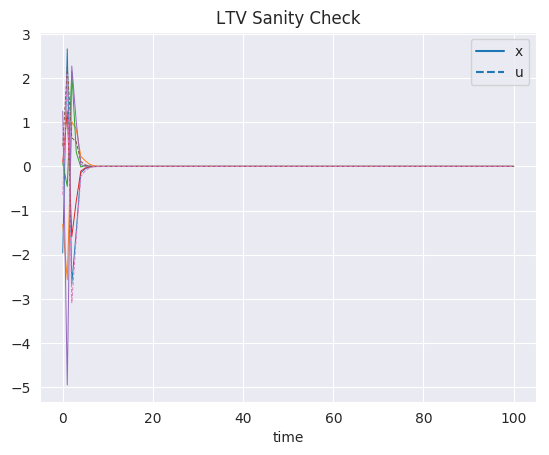

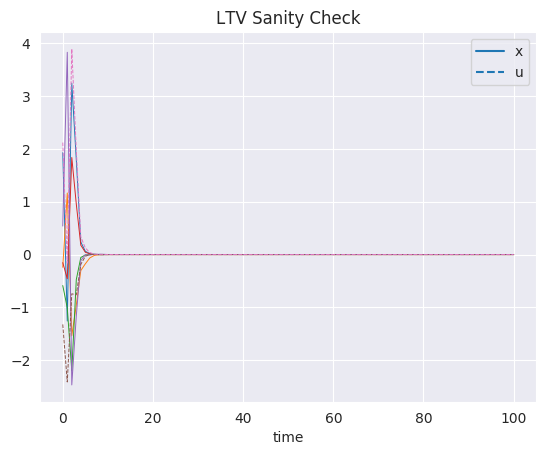

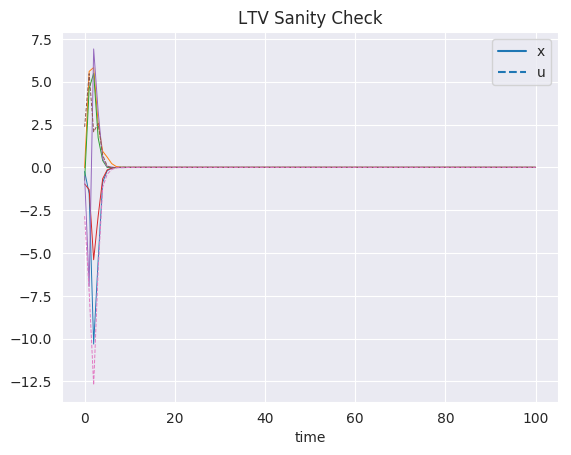

In [15]:
# here we define a LTV system for a fixed horizon
T = 100
A_lst = [np.array([[np.sin(t), -0.5049, 0.0299, 2.6544, 1.0608],
              [2.3846, -0.2312, -0.1260, -0.7945, 0.5279],
              [1.4019, -0.6394, -0.1401, 0.5484, 0.1624],                      
              [-0.0254, 0.4595, -0.0862, 2.1750, 1.1012],
              [0.5172, 0.5060, 1.6579, -0.9407, -1.4441]]) for t in range(T)] #Time varying state dynamics matrix
B_lst = [np.array([[-0.7789, -1.2076],
              [0.4299, -1.6041],
              [0.2006, -1.7395],
              [0.8302, 0.2295],
              [-1.8465, np.cos(t)]]) for t in range(T)]  #Time varying control dynamics matrix

starting_states = np.array([[-1.9613, 1.9277, -0.2442],
                            [-1.3127, -0.2406, -0.0260],
                            [0.0698, -0.5860, -0.7522],
                            [0.0935, -0.1524, -0.9680],
                            [1.2494, 0.5397, -0.5146]]) #Multiple possible starting states
n_starting_states = starting_states.shape[1]

dx, du = A_lst[0].shape[0], B_lst[0].shape[1] 
Q, R = np.eye(dx), np.eye(du)
K_lst, P_lst = lqr_finite_horizon(A_lst, B_lst, Q, R, T)

# fill in to use your controller
def simulate(A_lst, B_lst, K_list, n_starting_states, T, noise=None):
    for s in np.arange(n_starting_states):
        x, u = np.zeros((K_list[0].shape[1], T+1)), np.zeros((K_list[0].shape[0], T+1))
        x[:,0] = starting_states[:,s]
        for t in np.arange(T):
            """YOUR CODE HERE"""
            u[:,t] = K_lst[T-t-1]@x[:,t]
            """YOUR CODE ENDS HERE"""
            x[:,t+1] = A_lst[t] @ x[:,t] + B_lst[t] @ u[:,t]
            if noise is not None:
                x[:,t+1] += noise[:,t]
      
        plt.plot(x.T, linewidth=.7)
        plt.plot(np.squeeze(u.T), linewidth=.7, linestyle='--')
        legend_elements = [Line2D([0], [0], label='x'),Line2D([0], [0], linestyle='--', label='u')]
        plt.legend(handles=legend_elements)
        plt.xlabel('time')
        plt.title("LTV Sanity Check")
        plt.show()

# simulate to sanity check your TV solution
simulate(A_lst, B_lst, K_lst, n_starting_states, T)

#### (d) Trajectory Following for Nonlinear Systems

Given a feasible trajectory $\{ x_t, u_t\}_{t=0}^{H-1}$ , we define our optimization problem as follows:

$$\min_{u_0, ..., u_{H-1}} \sum_{t=0}^{H-1} (((x_t-x_t^*)' Q_t (x_t-x_t^*) + (u_t-u_t^*)' R_t (u_t-u_t^*))) \\ \text{s.t. }x_{t+1} = f(x_t, u_t)$$

Your task is to implement trajectory following for helicopter flight (non-linear system) by **transforming the objective into a LTV setting and running LQR.** We have provided (and loaded) the reference trajectory below, run the following cell to visualize the target trajectory. **Note that this trajectory is *approximately feasible*, so you will have to include an offset term to account for this.** 

HINT: for the offset, refer to the lecture and now use the optional argument to the `linearize_dynamics` function. Now, what to do with these offsets? Since we have written a time-varying LQR solver for linear systems, in order to use the same code, augment the "state" to include the offset in your A and B matrices.

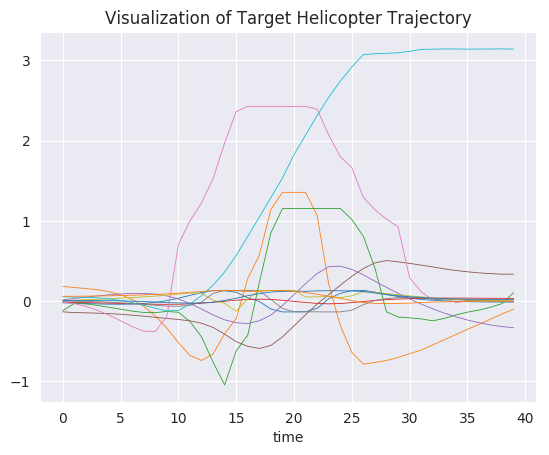

In [16]:
traj = loadmat("mats/heli_traj.mat")
x_init, x_target, u_target = traj['x_init'], traj['x_target'], traj['u_target']

plt.plot(x_target.T, linewidth = .6)
plt.title("Visualization of Target Helicopter Trajectory")
plt.xlabel("time")
plt.show()

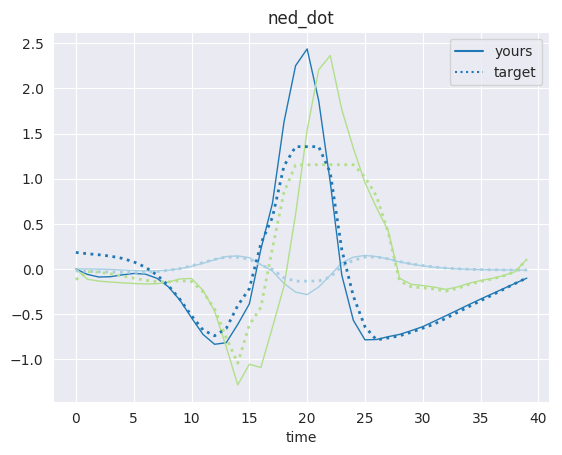

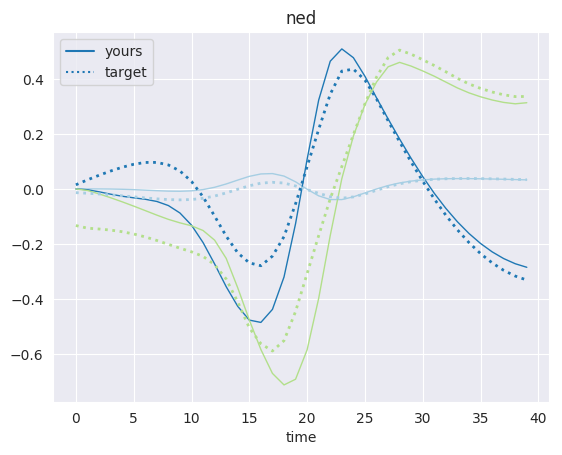

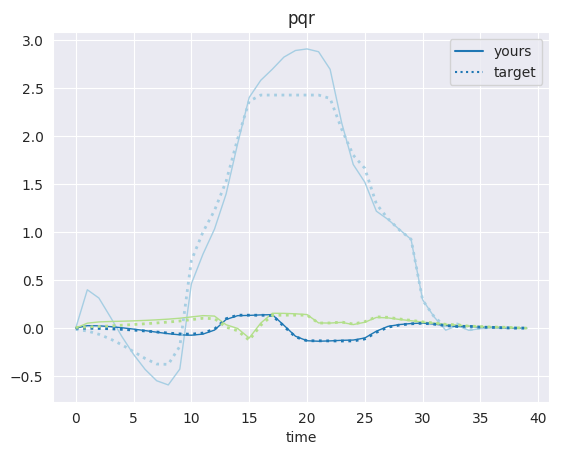

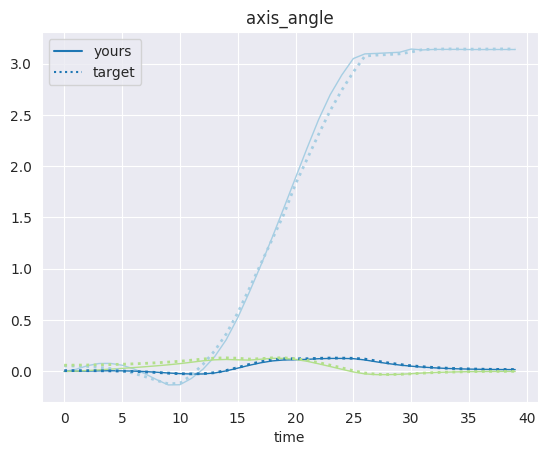

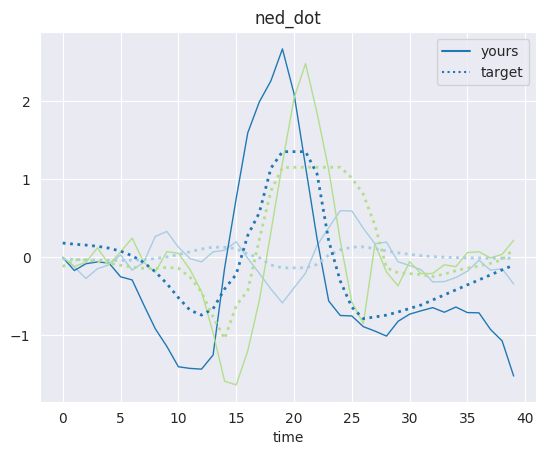

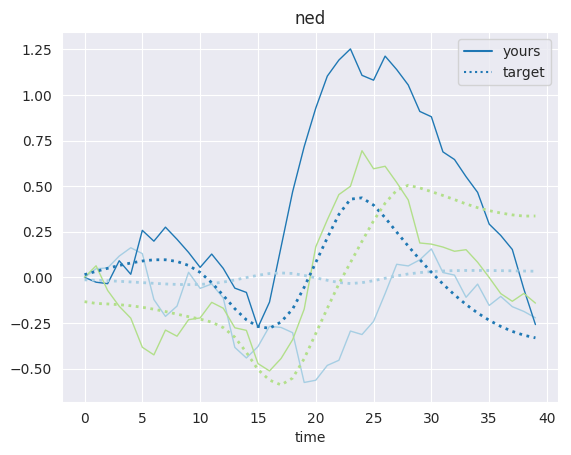

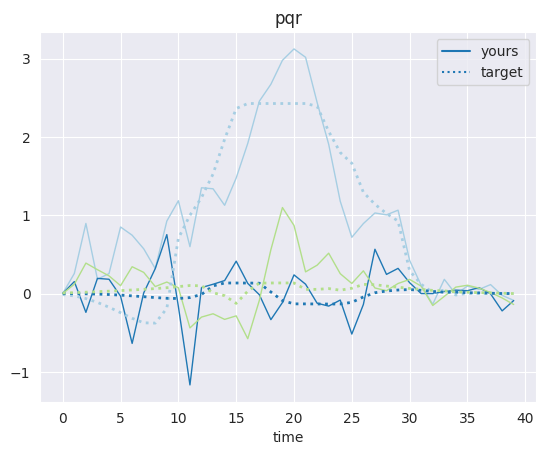

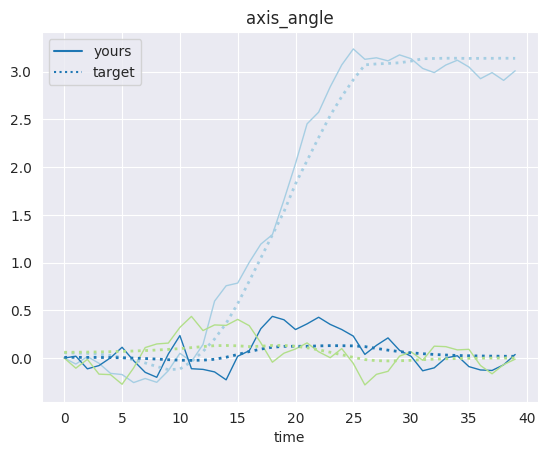

In [17]:
f = sim_heli
dt = 0.1 # we work with discrete time

x_ref, u_ref = x_target.T, u_target.T
my_eps = 0.001 # finite difference for numerical differentiation
T, dx = x_ref.shape
du = u_ref.shape[1]
A_lst, B_lst = [], [] # this should look familiar, maybe your code from part (c) will be helpful!

for t in range(T-1):
    """YOUR CODE HERE"""
    A, B, c = linearize_dynamics(f, x_ref[t], u_ref[t], dt, my_eps, 
                                 x_ref_tplus1=x_ref[t+1])
    A_t = np.append(np.append(A, 
                              np.zeros(A.shape[1]).reshape(1, -1), 
                              axis=0), 
                    np.append(c, 1).reshape(1, -1).T,
                    axis=1)    
    B_t = np.append(B, 
                    np.zeros(B.shape[1]).reshape(1, -1), 
                    axis=0)     
    """YOUR CODE ENDS HERE"""
    A_lst.append(A_t)
    B_lst.append(B_t)

Q, R = np.eye(A_lst[0].shape[0]), np.eye(B_lst[0].shape[1])
Q[-1, -1] = 0
K_list, P_list = lqr_finite_horizon(A_lst, B_lst, Q, R, T-1) # you wrote this in part (c)

# once again fill in the control input based on your controller
def simulate(K_lst, f, x_ref, u_ref, dt, n_starting_states, T, noise=None):
    def setup_heli_idx():
        idx = dict()
        k = 0
        keys = ["ned_dot", "ned", "pqr", "axis_angle"]
        for ky in range(len(keys)):
            idx[keys[ky]] = np.arange(k,k+3)
            k += 3
        return idx
    idx = setup_heli_idx()
    
    def disp(sim, ref, label):
        cp = sns.color_palette("Paired")
        a, b = sim[idx[label]], ref[idx[label]]
        [plt.plot(a[i], linewidth=1, color=cp[i]) for i in range(a.shape[0])]
        [plt.plot(b[i], linewidth=2, linestyle=':', color=cp[i]) for i in range(b.shape[0])]
        legend_elements = [Line2D([0], [0], label='yours'),Line2D([0], [0], linestyle=':', label='target')]
        plt.legend(handles=legend_elements)
        plt.xlabel('time')
        plt.title(label)
        plt.show()
        
    for s in np.arange(n_starting_states):
        x, u = np.zeros((x_ref.shape[1], T)), np.zeros((u_ref.shape[1], T))
        x[:,0] = starting_states[:,s]
        for t in np.arange(T-1):
            """YOUR CODE HERE"""
            z = np.append(x[:, t] - x_ref[t], 1)
            u[:,t] = (K_lst[T-2-t] @ z) + u_ref[t]
            """YOUR CODE ENDS HERE"""
            x[:,t+1] = f(x[:,t], u[:,t], dt)
            if noise is not None:
                x[:,t+1] += noise[:,t]
        keys = ["ned_dot", "ned", "pqr", "axis_angle"]
        for key in keys:
            disp(x, x_ref.T, key)
                 
                
# simulate (reference trajectory depicted by dotted lines)               
starting_states = x_init.reshape(-1,1)      
simulate(K_list, f, x_ref, u_ref, dt, 1, T)

# now with noise!
simulate(K_list, f, x_ref, u_ref, dt, 1, T, noise = np.random.normal(scale=.1, size=(x_ref.shape[1], T)))

Congratulations! You're finished with the programming exercises. Print preview -> print to pdf then include the pdf in your write up. 

Remember to complete the theory questions for the write-up as well!